### Converting a pytorch model to OpenVINO IR

<img src="openvino_mo.JPG">

where IR is a pair of files describing the model:

 - xml - Describes the network topology.

 - bin - Contains the weights and biases binary data.

In [1]:
from openvino.tools.mo import convert_model

# Quantization

Quantization is a technique to reduce the computational and memory costs of running inference by representing the weights and activations with low-precision data types like 8-bit integer (int8) instead of the usual 32-bit floating point (float32).

> 🤗 Optimum provides an optimum.onnxruntime package that enables you to apply quantization on many models hosted on the Hugging Face Hub using the ONNX Runtime quantization tool. <br> <br>
The quantization process is abstracted via the ORTConfig and the ORTQuantizer classes. The former allows you to specify how quantization should be done, while the latter effectively handles quantization.

#### Quantization to int8 [More info](https://huggingface.co/docs/optimum/concept_guides/quantization#quantization-to-int8)


Let’s consider a float x in [a, b]. The quantized value x_q of x in [a, b] can be computed as follows:

```python
x_q = round(x/S + Z)
```

And float32 values outside of the [a, b] range are clipped to the closest representable value, so for any floating-point number x:

```python
x_q = clip(round(x/S + Z), round(a/S + Z), round(b/S + Z))
```

<img src="quantization.JPG">

## Calibration

> how is the [a, b] range of float32 values determined? That is where calibration comes in to play.

Calibration is the step during quantization where the `float32` ranges are computed. 

For weights, it is quite easy since the actual range is known at quantization-time. But it is less clear for activations, and different approaches exist:

 - **Post training dynamic quantization**: the range for each activation is computed on the fly at runtime. While this gives great results without too much work, it can be a bit slower than static quantization because of the overhead introduced by computing the range each time. It is also not an option on certain hardware.
<br>

 - **Post training static quantization**: the range for each activation is computed in advance at quantization-time, typically by passing representative data through the model and recording the activation values. In practice, the steps are:

   1. Observers are put on activations to record their values.

   2. A certain number of forward passes on a calibration dataset is done (around 200 examples is enough).

   3. The ranges for each computation are computed according to some calibration technique.
<br>

 - **Quantization aware training**: the range for each activation is computed at training-time, following the same idea than post training static quantization. But “fake quantize” operators are used instead of observers: they record values just as observers do, but they also simulate the error induced by quantization to let the model adapt to it.
 
 
For both post training static quantization and quantization aware training, it is necessary to define calibration techniques, the most common are:

 - Min-max: the computed range is `[min observed value, max observed value]`, this works well with weights.


 - Moving average min-max: the computed range is `[moving average min observed value, moving average max observed value]`, this works well with activations.


 - Histogram: records a histogram of values along with min and max values, then chooses according to some criterion:


     - Entropy: the range is computed as the one minimizing the error between the full-precision and the quantized data.


     - Mean Square Error: the range is computed as the one minimizing the mean square error between the full-precision and the quantized data.


     - Percentile: the range is computed using a given percentile value p on the observed values. The idea is to try to have p% of the observed values in the computed range. While this is possible when doing affine quantization, it is not always possible to exactly match that when doing symmetric quantization.


## Model optimization

Model optimization is an optional offline step of improving the final model performance and reducing the model size by applying special optimization methods, such as **8-bit quantization**, **pruning**, etc. OpenVINO offers two optimization paths implemented in Neural Network Compression Framework (NNCF):


 - **Post-training Quantization** is designed to optimize the inference of deep learning models by applying the post-training 8-bit integer quantization that does not require model retraining or fine-tuning.

<br>

 - **Training-time Optimization**, a suite of advanced methods for training-time model optimization within the DL framework, such as PyTorch and TensorFlow 2.x. It supports methods like Quantization-aware Training, Structured and Unstructured Pruning, etc.

Post-training Quantization is the fastest way to optimize a model and should be applied first, but it is limited in terms of achievable accuracy-performance trade-off. In case of poor accuracy or performance after Post-training Quantization, Training-time Optimization can be used as an option.

<img src="./openvino_optimization.JPG">

NNCF API has two main capabilities to apply 8-bit post-training quantization:

 - **Basic quantization** - applies 8-bit integer quantization to the model. A representative calibration dataset is only needed in this case.
<br>

 - **Quantization with accuracy control** - allows applying 8-bit quantization to the model with accuracy control. Calibration and validation datasets, and a validation function to calculate the accuracy metric are needed in this case.

In [2]:
import os
import openvino
import nncf
import onnx
import torch

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


In [3]:
dataset_path = os.path.join(os.environ["DATASETS"], "vegetables", "Vegetable-Images", "validation")
dataset_path

'C:\\Users\\Harry\\Documents\\DS\\Datasets\\vegetables\\Vegetable-Images\\validation'

In [4]:
labels_txt = os.listdir(dataset_path)
labels_txt

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [70]:
def to_numpy(tensor):
    """
    REQUIRES_GRAD: Is True if gradients need to be computed for this Tensor, False otherwise.
    """
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


def predict_and_plot(model, test_image):
    res = model_int8(test_image)
    img_out_y = res[0]
    print(img_out_y)
    pred_label = labels_txt[img_out_y[0].argmax(0)]

    if not isinstance(test_image, np.ndarray):
        to_img = ToPILImage()
        img = to_img(test_image[0])
    else:
        img = np.squeeze(test_image).transpose(1, 2, 0).astype(np.uint8)

    plt.figure(figsize=(6, 6))
    plt.title(pred_label)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

**Quantization** is the process of converting the weights and activation values in a neural network from a high-precision format (such as 32-bit floating point) to a lower-precision format (such as 8-bit integer). It helps to reduce the model’s memory footprint and latency. NNCF uses quantization-aware training to quantize models.


Quantization-aware training inserts nodes into the neural network during training that simulate the effect of lower precision. This allows the training algorithm to consider quantization errors as part of the overall training loss that gets minimized during training. The network is then able to achieve enhanced accuracy when quantized.

<img src="quantization.JPG">

### Preparing Caliberation Dataset

In [11]:
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, ToPILImage

In [12]:
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [9]:
data = ImageFolder(dataset_path, transform=transform)

In [10]:
type(data)

torchvision.datasets.folder.ImageFolder

In [11]:
isinstance(data, Dataset)

True

In [12]:
isinstance(data, DataLoader)

False

In [13]:
next(iter(data))[0].shape

torch.Size([3, 224, 224])

In [14]:
def transform_fn(data_item):
    images, _ = data_item
    return images

In [15]:
caliberation_dataloader = DataLoader(data, batch_size=32, shuffle=True, num_workers=2)

In [16]:
calibration_dataset = nncf.Dataset(caliberation_dataloader, transform_fn)

In [17]:
type(calibration_dataset)

nncf.data.dataset.Dataset

In [18]:
dir(calibration_dataset)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_data_source',
 '_is_protocol',
 '_nncf_api_marker',
 '_nncf_canonical_alias',
 '_transform_func',
 'get_data',
 'get_inference_data']

### Quantize a model

In [6]:
from torchvision.models import ResNet50_Weights, resnet50
from torch.nn import Linear
from torch import device, load

In [20]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = Linear(2048, 15)

saved_model = load("./models/vegetables.pt", map_location=device('cpu'))
model.load_state_dict(saved_model["model_state_dict"])

quantized_model = nncf.quantize(model, calibration_dataset)

No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.2'


INFO:nncf:Collecting tensor statistics |█               | 1 / 10
INFO:nncf:Collecting tensor statistics |███             | 2 / 10
INFO:nncf:Collecting tensor statistics |████            | 3 / 10
INFO:nncf:Collecting tensor statistics |██████          | 4 / 10
INFO:nncf:Collecting tensor statistics |████████        | 5 / 10
INFO:nncf:Collecting tensor statistics |█████████       | 6 / 10
INFO:nncf:Collecting tensor statistics |███████████     | 7 / 10
INFO:nncf:Collecting tensor statistics |████████████    | 8 / 10
INFO:nncf:Collecting tensor statistics |██████████████  | 9 / 10
INFO:nncf:Collecting tensor statistics |████████████████| 10 / 10
INFO:nncf:Compiling and loading torch extension: quantized_functions_cpu...


C:\Python11\Lib\site-packages\torch\utils\cpp_extension.py:359: UserWarning: Error checking compiler version for cl: [WinError 2] The system cannot find the file specified
  warnings.warn(f'Error checking compiler version for {compiler}: {error}')


Reason: Command '['where', 'cl']' returned non-zero exit status 1.
INFO:nncf:Finished loading torch extension: quantized_functions_cpu
INFO:nncf:BatchNorm statistics adaptation |█               | 1 / 10
INFO:nncf:BatchNorm statistics adaptation |███             | 2 / 10
INFO:nncf:BatchNorm statistics adaptation |████            | 3 / 10
INFO:nncf:BatchNorm statistics adaptation |██████          | 4 / 10
INFO:nncf:BatchNorm statistics adaptation |████████        | 5 / 10
INFO:nncf:BatchNorm statistics adaptation |█████████       | 6 / 10
INFO:nncf:BatchNorm statistics adaptation |███████████     | 7 / 10
INFO:nncf:BatchNorm statistics adaptation |████████████    | 8 / 10
INFO:nncf:BatchNorm statistics adaptation |██████████████  | 9 / 10
INFO:nncf:BatchNorm statistics adaptation |████████████████| 10 / 10


After that the model can be converted into the OpenVINO Intermediate Representation (IR) if needed, compiled and run with OpenVINO.

In [7]:
from PIL import Image

In [13]:
img = Image.open(os.path.join(os.environ["DATASETS"], "vegetables", "Vegetable-Images", "test", "Carrot", "1001.jpg"))

resize = Compose([
    Resize([224, 224]),
    ToTensor()
])

img = resize(img).unsqueeze_(0)
img.shape

torch.Size([1, 3, 224, 224])

In [8]:
from torch import randn, onnx

In [9]:
import openvino.runtime as ov
from openvino.tools.mo import convert_model

In [25]:
input_fp32 = randn(1, 3, 224, 224, requires_grad=True).to("cpu")  # FP32 input to model

# export PyTorch model to ONNX model
onnx_model_path = "./models/vegetable_2.onnx"
torch.onnx.export(quantized_model, input_fp32, onnx_model_path)

# convert ONNX model to OpenVINO model
ov_quantized_model = convert_model(onnx_model_path)

# compile the model to transform quantized operations to int8, get inference
model_int8 = ov.compile_model(ov_quantized_model)
res = model_int8(img)

# save the model
ov.serialize(ov_quantized_model, "./models/vegetables_quantized_model.xml")

============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [26]:
res

{<ConstOutput: names[1428] shape[1,15] type: f32>: array([[-0.7905667 , -2.05604   , -0.8591321 , -2.0120666 , -0.8535765 ,
        -0.7454275 ,  0.12820752,  3.7078688 , -0.5515211 , -2.484529  ,
        -2.6199389 ,  1.0331672 , -1.4075308 ,  8.128693  ,  0.15504843]],
      dtype=float32)}

In [36]:
res[0][0]

array([-0.7905667 , -2.05604   , -0.8591321 , -2.0120666 , -0.8535765 ,
       -0.7454275 ,  0.12820752,  3.7078688 , -0.5515211 , -2.484529  ,
       -2.6199389 ,  1.0331672 , -1.4075308 ,  8.128693  ,  0.15504843],
      dtype=float32)

In [39]:
res[0][0].argmax(0)

13

#### Testing accuracy

In [16]:
test_dataset_path = os.path.join(os.environ["DATASETS"], "vegetables", "Vegetable-Images", "test")
test_data = ImageFolder(test_dataset_path, transform=resize)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)

In [17]:
test_data_itr = iter(test_data)

In [24]:
test_data.__len__()

3000

In [18]:
next(test_data_itr)[0].shape

torch.Size([3, 224, 224])

In [20]:
next(test_data_itr)[1]

0

[[ 0.37014115 -1.0685793  -1.4860806  -1.8584384   7.6649885   0.09094445
   0.04491471 -1.6536391   0.19447689 -3.0107749  -2.1586716  -1.0384395
  -0.90786076  0.37851164  2.1466844 ]]


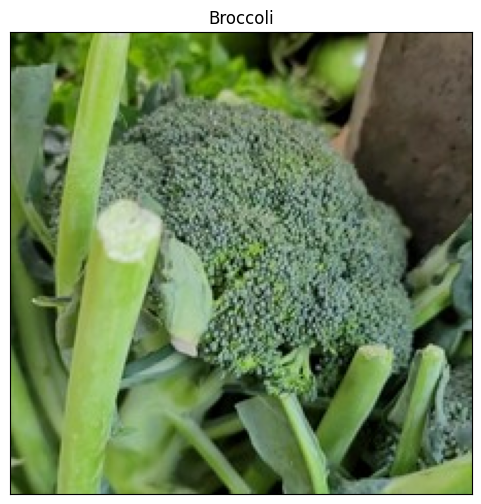

In [97]:
im, _ = next(test_data_itr)
im.unsqueeze_(0)
predict_and_plot(model_int8, im)

In [21]:
from openvino.runtime import Core

In [22]:
core = Core()
vegetables_quantized_model = "models/vegetables_quantized_model.xml"

model = core.read_model(model=vegetables_quantized_model)
compiled_model = core.compile_model(model=model, device_name="CPU")

In [23]:
model_int8 = compiled_model

In [31]:
def predict_acc(model, data_itr):
    labels = np.zeros(shape=(len(test_data), 1))
    preds = np.zeros(shape=(len(test_data), 1))
    
    i = 0
    for img, label in data_itr:
        im = img[np.newaxis, ...]
        res = model(im)
        pred = res[0][0].argmax(0)
        
        print(f"Predicted vegetable: {labels_txt[pred]}, actual vegetable: {labels_txt[label]}")

        labels[0, i] = label
        preds[0, i] = pred
        
        i += 1
        
    return labels, preds

In [32]:
y_true, y_pred = predict_acc(model_int8, test_data_itr)

Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Bean, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetable: Broccoli, actual vegetable: Broccoli
Predicted vegetabl

Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: Cabbage
Predicted vegetable: Cabbage, actual vegetable: 

Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vegetable: Capsicum, actual vegetable: Capsicum
Predicted vege

Predicted vegetable: Carrot, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Carrot, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Carrot, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Carrot, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish,

Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Carrot, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Carrot, actual vegetable: Carrot
Predicted vegetable: Carrot, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Carrot, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Carrot, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish, actual vegetable: Carrot
Predicted vegetable: Radish,

Predicted vegetable: Cauliflower, actual vegetable: Cauliflower
Predicted vegetable: Cabbage, actual vegetable: Cauliflower
Predicted vegetable: Cauliflower, actual vegetable: Cauliflower
Predicted vegetable: Cauliflower, actual vegetable: Cauliflower
Predicted vegetable: Cauliflower, actual vegetable: Cauliflower
Predicted vegetable: Cauliflower, actual vegetable: Cauliflower
Predicted vegetable: Cauliflower, actual vegetable: Cauliflower
Predicted vegetable: Cauliflower, actual vegetable: Cauliflower
Predicted vegetable: Cauliflower, actual vegetable: Cauliflower
Predicted vegetable: Cauliflower, actual vegetable: Cauliflower
Predicted vegetable: Cabbage, actual vegetable: Cauliflower
Predicted vegetable: Cauliflower, actual vegetable: Cauliflower
Predicted vegetable: Cauliflower, actual vegetable: Cauliflower
Predicted vegetable: Cauliflower, actual vegetable: Cauliflower
Predicted vegetable: Cauliflower, actual vegetable: Cauliflower
Predicted vegetable: Cauliflower, actual vegetab

Predicted vegetable: Cabbage, actual vegetable: Cucumber
Predicted vegetable: Cucumber, actual vegetable: Cucumber
Predicted vegetable: Potato, actual vegetable: Cucumber
Predicted vegetable: Potato, actual vegetable: Cucumber
Predicted vegetable: Cucumber, actual vegetable: Cucumber
Predicted vegetable: Potato, actual vegetable: Cucumber
Predicted vegetable: Bean, actual vegetable: Cucumber
Predicted vegetable: Potato, actual vegetable: Cucumber
Predicted vegetable: Radish, actual vegetable: Cucumber
Predicted vegetable: Potato, actual vegetable: Cucumber
Predicted vegetable: Cucumber, actual vegetable: Cucumber
Predicted vegetable: Cucumber, actual vegetable: Cucumber
Predicted vegetable: Cucumber, actual vegetable: Cucumber
Predicted vegetable: Radish, actual vegetable: Cucumber
Predicted vegetable: Cucumber, actual vegetable: Cucumber
Predicted vegetable: Potato, actual vegetable: Cucumber
Predicted vegetable: Cucumber, actual vegetable: Cucumber
Predicted vegetable: Radish, actual

Predicted vegetable: Cucumber, actual vegetable: Cucumber
Predicted vegetable: Cucumber, actual vegetable: Cucumber
Predicted vegetable: Radish, actual vegetable: Cucumber
Predicted vegetable: Potato, actual vegetable: Cucumber
Predicted vegetable: Potato, actual vegetable: Cucumber
Predicted vegetable: Cucumber, actual vegetable: Cucumber
Predicted vegetable: Cucumber, actual vegetable: Cucumber
Predicted vegetable: Potato, actual vegetable: Cucumber
Predicted vegetable: Potato, actual vegetable: Cucumber
Predicted vegetable: Cucumber, actual vegetable: Cucumber
Predicted vegetable: Radish, actual vegetable: Cucumber
Predicted vegetable: Cucumber, actual vegetable: Cucumber
Predicted vegetable: Potato, actual vegetable: Papaya
Predicted vegetable: Cabbage, actual vegetable: Papaya
Predicted vegetable: Potato, actual vegetable: Papaya
Predicted vegetable: Tomato, actual vegetable: Papaya
Predicted vegetable: Capsicum, actual vegetable: Papaya
Predicted vegetable: Potato, actual vegetab

Predicted vegetable: Potato, actual vegetable: Papaya
Predicted vegetable: Potato, actual vegetable: Papaya
Predicted vegetable: Capsicum, actual vegetable: Papaya
Predicted vegetable: Capsicum, actual vegetable: Papaya
Predicted vegetable: Tomato, actual vegetable: Papaya
Predicted vegetable: Papaya, actual vegetable: Papaya
Predicted vegetable: Tomato, actual vegetable: Papaya
Predicted vegetable: Potato, actual vegetable: Papaya
Predicted vegetable: Potato, actual vegetable: Papaya
Predicted vegetable: Potato, actual vegetable: Papaya
Predicted vegetable: Capsicum, actual vegetable: Papaya
Predicted vegetable: Potato, actual vegetable: Papaya
Predicted vegetable: Capsicum, actual vegetable: Papaya
Predicted vegetable: Capsicum, actual vegetable: Papaya
Predicted vegetable: Tomato, actual vegetable: Papaya
Predicted vegetable: Potato, actual vegetable: Papaya
Predicted vegetable: Potato, actual vegetable: Papaya
Predicted vegetable: Capsicum, actual vegetable: Papaya
Predicted vegeta

Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Radish, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato, actual vegetable: Potato
Predicted vegetable: Potato,

Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Cabbage, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Cabbage, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Cabbage, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Cabbage, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: 

Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Cabbage, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Pumpkin, actual vegetable: Pumpkin
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetabl

Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish, actual vegetable: Radish
Predicted vegetable: Radish,

Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato, actual vegetable: Tomato
Predicted vegetable: Tomato,

In [33]:
from sklearn.metrics import f1_score, confusion_matrix

In [41]:
y_pred = y_pred.reshape((3000, 1))
y_true = y_true.reshape((3000, 1))

In [42]:
confusion_matrix(y_true, y_pred)

array([[971,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,  28,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 193,   0,   0,   0,   0,   7,   0,   0,   0],
       [  0,   0,   0,   0,   0,  45,   0,   0,   0,  10,   0, 145,   0],
       [  0,   0,   0,   9,   0,   0, 191,   0,   0,   0,   0,   0,   0],
       [  7,   3,   0,   7,   2,   0,   4,  78,   0,  71,   0,  25,   3],
       [  0,   0,   0,  15,  71,   0,   0,   0,  12,  72,   0,   0,  30],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 199,   0,   1,   0],
       [  0,   0,   0,  44,   1,   0,   0,   0,   0,   1, 154,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 200,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0, 199]],
      dtype=int64)

In [44]:
f1_score(y_true, y_pred, average="weighted")

0.7904210461894184